In [1]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView, pbfs_search, BFSVisitor, Graph, min_spanning_tree
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.1

pos = graphviz_layout(gnx, root=0)

In [10]:
from steiner_tree_mst import init_visitor, cpbfs_search, get_edges, steiner_tree_mst
def build_truncated_closure(g, cand_source, terminals, infection_times, k=-1,
                            debug=False,
                            verbose=False,
                            **kawrgs):
    """
    build a clojure graph in which cand_source + terminals are all connected to each other.
    the number of neighbors of each node is determined by k

    the larger the k, the denser the graph"""
    r2pred = {}
    edges = {}
    terminals = list(terminals)

    # from cand_source to terminals
    vis = init_visitor(g, cand_source)

    cpbfs_search(g, source=cand_source, visitor=vis, terminals=terminals,
                 forbidden_nodes=terminals,
                 count_threshold=-1)  # k=-1 here because root connects to all other nodes
    r2pred[cand_source] = vis.pred
    for u, v, c in get_edges(vis.dist, cand_source, terminals):
        edges[(u, v)] = c
    if debug:
        print('cand_source: {}'.format(cand_source))
        print('#terminals: {}'.format(len(terminals)))
        print('edges from cand_source: {}'.format(edges))

    if verbose:
        terminals_iter = tqdm(terminals)
        print('building closure graph')
    else:
        terminals_iter = terminals

    # from terminal to other terminals
    # every temrinal should connetct to at least one earlier terminal
    # in this way, connectivity is ensured
    for root in terminals_iter:
        if root == cand_source:
            continue            
        # connect from some earlier node to root

        # if it's earliest, can only connect to peers        
        early_terminals = [t for t in terminals
                           if infection_times[t] < infection_times[root]]
        same_time_terminals = [t for t in terminals
                               if infection_times[t] == infection_times[root] if t != root]
        late_time_terminals = [t for t in terminals
                               if infection_times[t] > infection_times[root]]
        if debug:
            print('root: {}'.format(root))
            print('early_terminals: {}'.format(early_terminals))
            print('same_time_terminals: {}'.format(same_time_terminals))
            print('late_time_terminals: {}'.format(late_time_terminals))

        if infection_times[root] == infection_times[terminals].min():
            targets = early_terminals + same_time_terminals            
        else:
            targets = early_terminals

        targets = list(set(targets) - {cand_source})  # no one can connect to cand_source

        if debug:
            print('targets: {}'.format(targets))
            
        vis = init_visitor(g, root)            
        cpbfs_search(g, source=root, visitor=vis, 
                     terminals=targets,
                     forbidden_nodes=late_time_terminals,
                     count_threshold=k)
        r2pred[root] = vis.pred
        for root, v, c in get_edges(vis.dist, root, early_terminals):
            if debug:
                print('edge ({}, {})'.format(v, root))
            edges[(v, root)] = c  # from earlier node to root

    if verbose:
        print('returning closure graph')

    gc = Graph(directed=True)

    for _ in range(g.num_vertices()):
        gc.add_vertex()

    for (u, v) in edges:
        gc.add_edge(u, v)

    eweight = gc.new_edge_property('int')
    eweight.set_2d_array(np.array(list(edges.values())))

    return gc, eweight, r2pred

In [13]:
from utils import earliest_obs_node
from tqdm import tqdm
from feasibility import is_order_respected, is_feasible
# from steiner_tree_region_mst import steiner_tree_region_mst

for i in tqdm(range(100)):
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='si', return_tree=True)
    root = earliest_obs_node(obs_nodes, infection_times)

    tree, gc, mst_tree = steiner_tree_mst(
        g, root, infection_times, source, obs_nodes,
        closure_builder=build_truncated_closure,
        k=1,
        debug=False,
        verbose=False,
        return_closure=True
    )
    assert is_order_respected(tree, root, obs_nodes, infection_times)
    assert is_feasible(tree, root, obs_nodes, infection_times)


 25%|██▌       | 25/100 [00:20<01:00,  1.25it/s]]

<IPython.core.display.Javascript object>


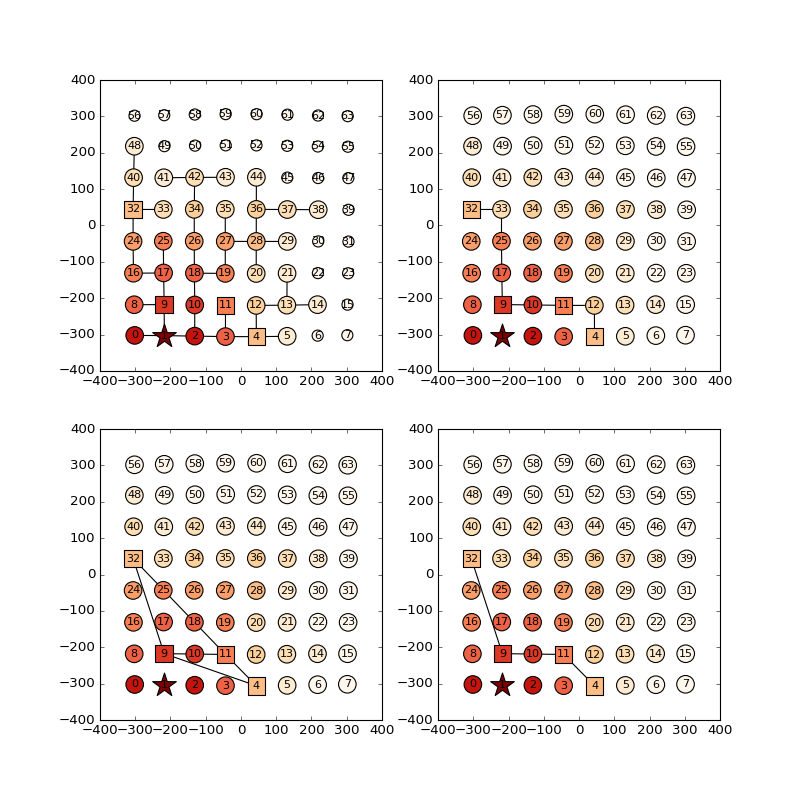

In [14]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
             ax=ax[0, 1], arrows=True,
             edges=extract_edges(tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0], arrows=True,
              edges=extract_edges(gc))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 1], arrows=True,
              edges=extract_edges(mst_tree))